# Práctica Deep Learning - Máximo Lloris

# Modelo 1D/tabular

## 1. Importación de librerías

In [ ]:
import cv2
import keras
import random
import numpy  as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, Activation, Conv2D, GlobalAveragePooling2D, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import imageio.v3 as io
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tqdm import tqdm
from typing import Optional, Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam

## 2. Carga de datos

In [2]:
# SEMILLA > Para conseguir replicabilidad
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


import pandas as pd

# Ruta relativa al archivo en tu Google Drive
ruta_archivo = 'data_KC.csv'

# Monta tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Lee el archivo CSV en un DataFrame de pandas
data = pd.read_csv(f'/content/drive/My Drive/keepcoding_DL/data_KC.csv', sep = ';', header=0)

# elimino columnas
columns_to_drop = ['id','amenities', 'name', 'thumbnail_url', 'description', 'first_review',
                   'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'last_review']

data = data.drop(columns=columns_to_drop)


#Paso a categorico mi variable objetivo
# Supongamos que 'data' es tu DataFrame
data['Price_Category'] = pd.cut(data['Price'],
                                bins=[-float('inf'), 86, 150, float('inf')],
                                labels=['Cheap', 'Middle', 'Expensive'])

Mounted at /content/drive


## 3. División entre Train, test y validacion

In [3]:
X = data.drop(columns=['Price_Category'])
y = data['Price_Category']

# Divide los datos en conjuntos de entrenamiento (train_val) y test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify= y)

# Divide los datos de entrenamiento (train_val) en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=seed, stratify=y_train_val)


In [4]:
#Creamos indices
idx_train = y_train.index.values
idx_val = y_val.index.values
idx_test = y_test.index.values


# Guardo los index
np.save('/content/drive/MyDrive/keepcoding_DL/idx_train.npy', idx_train)
np.save('/content/drive/MyDrive/keepcoding_DL/idx_val.npy', idx_val)
np.save('/content/drive/MyDrive/keepcoding_DL/idx_test.npy', idx_test)


## 4. Tratamiento de nulos

- Algunas de las variables tienen valores ausentes por lo que vamos a imputar en estos registros los valores de la media.

- Calculo la media para cada una de la comunas con valores numericos

In [5]:
# Calcula las medias para las columnas específicas
media_columns = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds']
column_means = {col: X_train[col].mean() for col in media_columns}

def preprocess_data(X_partition):
    # Rellena los valores nulos en columnas específicas con la media correspondiente
    for col in media_columns:
        X_partition[col].fillna(column_means[col], inplace=True)

    # Elimina las columnas no deseadas
    columns_to_drop = ['neighbourhood', 'zipcode', 'cleaning_fee']
    X_partition = X_partition.drop(columns=columns_to_drop)

    return X_partition

# Ejemplo de uso
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)
X_test = preprocess_data(X_test)


## 5. Codificación de variables categóricas

- Para manejar nuevas etiquetas en los conjuntos de validación (X_val) o prueba (X_test) que no aparecieron en el conjunto de entrenamiento (X_train), extiendo LabelEncoder para manejar automáticamente etiquetas desconocidas asignándolas a una categoría 'AA_inexistente_en_X_train'.

- Esta codificación asignara un valor numerico a cada etiqueta del conjunto de X_train y creara una ultima etiqueta llamada 'AA_inexistente_en_X_train' que define la codificación para valores de etiqueta con los que no se ha entrenado el modelo

In [6]:
class ExtendedLabelEncoder(LabelEncoder):
    def __init__(self, unknown_label='AA_inexistente_en_X_train'):
        # Constructor de la clase, donde se inicializa la etiqueta para valores desconocidos.
        # `unknown_label` es la etiqueta que se asignará a cualquier clase que no se haya visto durante el fit.
        self.unknown_label = unknown_label
        super().__init__()

    def fit(self, y):
        # Sobreescribir el método fit para incluir la etiqueta desconocida en el entrenamiento.
        # Esto garantiza que cualquier valor desconocido que se encuentre durante el transform pueda ser codificado.
        # Se añade `unknown_label` a las clases que el encoder aprende.
        super().fit(np.append(y, self.unknown_label))
        return self

    def transform(self, y):
        # Sobreescribir el método transform para manejar correctamente los valores desconocidos.
        # Se transforma el array de entrada, reemplazando cualquier valor desconocido con `unknown_label`.
        # Esto se hace antes de pasar los datos al método transform original para evitar errores.
        new_y = np.array([x if x in self.classes_ else self.unknown_label for x in y])
        return super().transform(new_y)

    def fit_transform(self, y, *args, **kwargs):
        # Sobreescribir el método fit_transform para integrar los cambios en fit y transform.
        # Esto asegura que cuando fit_transform se llame, se manejen los valores desconocidos.
        return self.fit(y).transform(y)

### 5.1 Variables  predictoras

In [7]:
# Lista de todas las columnas no numéricas en X_train
columnas_no_numericas = X_train.select_dtypes(include=['object']).columns.tolist()

encoders = {}

for columna in columnas_no_numericas:
    le = ExtendedLabelEncoder()
    X_train[columna + '_codificada'] = le.fit_transform(X_train[columna].astype(str))
    encoders[columna] = le

# Ahora usa el encoder modificado para transformar X_val y X_test
for columna in columnas_no_numericas:
    le = encoders[columna]
    X_val[columna + '_codificada'] = le.transform(X_val[columna].astype(str))
    X_test[columna + '_codificada'] = le.transform(X_test[columna].astype(str))

In [8]:
for columna, encoder in encoders.items():
    print(f"Codificación para {columna}: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")

Codificación para property_type: {'AA_inexistente_en_X_train': 0, 'Apartment': 1, 'Bed & Breakfast': 2, 'Boat': 3, 'Boutique hotel': 4, 'Bungalow': 5, 'Camper/RV': 6, 'Castle': 7, 'Condominium': 8, 'Dorm': 9, 'Guest suite': 10, 'Guesthouse': 11, 'House': 12, 'In-law': 13, 'Loft': 14, 'Other': 15, 'Timeshare': 16, 'Townhouse': 17, 'Villa': 18}
Codificación para room_type: {'AA_inexistente_en_X_train': 0, 'Entire home/apt': 1, 'Private room': 2, 'Shared room': 3}
Codificación para bed_type: {'AA_inexistente_en_X_train': 0, 'Airbed': 1, 'Couch': 2, 'Futon': 3, 'Pull-out Sofa': 4, 'Real Bed': 5}
Codificación para cancellation_policy: {'AA_inexistente_en_X_train': 0, 'flexible': 1, 'moderate': 2, 'strict': 3, 'super_strict_30': 4}
Codificación para city: {'AA_inexistente_en_X_train': 0, 'Boston': 1, 'Chicago': 2, 'DC': 3, 'LA': 4, 'NYC': 5, 'SF': 6}
Codificación para instant_bookable: {'AA_inexistente_en_X_train': 0, 'f': 1, 't': 2}


### 5.2 Variables Objetivo

In [9]:
# Label encoding para la variable objetivo
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)

# Función para transformar y manejar valores desconocidos en la variable objetivo
def transform_target(le, series):
    unique_classes = set(le_y.classes_)
    return series.map(lambda x: le_y.transform([x])[0] if x in unique_classes else -1)

# Transformar y_val y y_test
y_val_encoded = transform_target(le_y, y_val)
y_test_encoded = transform_target(le_y, y_test)

y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

In [10]:
# Muestra las clases y sus correspondientes etiquetas codificadas
label_mapping = dict(zip(le_y.classes_, range(len(le_y.classes_))))
print("Mapeo de etiquetas codificadas:", label_mapping)

Mapeo de etiquetas codificadas: {'Cheap': 0, 'Expensive': 1, 'Middle': 2}


In [21]:
# Comprobacion categoria
categoria_1 = le_y.inverse_transform([1])[0]
categoria_1

'Expensive'

In [12]:
def procesar_datos(X_partition, y_partition):
    # Filtrar las columnas de tipo "object"
    columnas_object = X_partition.select_dtypes(include=['object'])

    # Eliminar las columnas de tipo "object"
    X_partition = X_partition.drop(columns=columnas_object.columns)

    # Convierte X_partition y y_partition a tipo float32
    X_partition = np.asarray(X_partition).astype(np.float32)
    y_partition = np.asarray(y_partition).astype(np.float32)


    return X_partition, y_partition


# Ejemplo de uso
X_train, y_train = procesar_datos(X_train, y_train)
X_val, y_val = procesar_datos(X_val, y_val)
X_test, y_test = procesar_datos(X_test, y_test)

In [13]:
# Instancia el escalador
scaler = preprocessing.StandardScaler()

# Ajusta el escalador solo en el conjunto de entrenamiento
scaler.fit(X_train)

# Transforma los conjuntos de entrenamiento, validación y prueba
XtrainScaled = scaler.transform(X_train)
XvalScaled = scaler.transform(X_val)
XtestScaled = scaler.transform(X_test)

X_train = XtrainScaled
X_val = XvalScaled
X_test = XtestScaled

In [14]:
# Datos a one-hot-encoding
depth = len(le_y.classes_)
y_train_onehot = tf.one_hot(y_train, depth=depth)
y_val_onehot = tf.one_hot(y_val, depth=depth)
y_test_onehot = tf.one_hot(y_test, depth=depth)

In [15]:

# Datos en el mismo formato
y_train = y_train_onehot
y_val = y_val_onehot
y_test = y_test_onehot


In [ ]:
np.save('/content/drive/MyDrive/keepcoding_DL/X_train.npy', X_train)
np.save('/content/drive/MyDrive/keepcoding_DL/X_val.npy', X_val)
np.save('/content/drive/MyDrive/keepcoding_DL/X_test.npy', X_test)

In [ ]:
np.save('/content/drive/MyDrive/keepcoding_DL/y_train.npy', y_train)
np.save('/content/drive/MyDrive/keepcoding_DL/y_val.npy', y_val)
np.save('/content/drive/MyDrive/keepcoding_DL/y_test.npy', y_test)

## 6. Red Neuronal funcional con Keras

[INFO]: Entrenando red neuronal...
Epoch 1/400
3/3 [==============================] - 6s 468ms/step - loss: 1.0761 - accuracy: 0.4019 - val_loss: 1.0679 - val_accuracy: 0.3889
Epoch 2/400
3/3 [==============================] - 0s 56ms/step - loss: 1.0682 - accuracy: 0.4085 - val_loss: 1.0611 - val_accuracy: 0.4064
Epoch 3/400
3/3 [==============================] - 0s 72ms/step - loss: 1.0608 - accuracy: 0.4180 - val_loss: 1.0545 - val_accuracy: 0.4240
Epoch 4/400
3/3 [==============================] - 0s 100ms/step - loss: 1.0538 - accuracy: 0.4422 - val_loss: 1.0483 - val_accuracy: 0.4474
Epoch 5/400
3/3 [==============================] - 0s 90ms/step - loss: 1.0472 - accuracy: 0.4531 - val_loss: 1.0422 - val_accuracy: 0.4561
Epoch 6/400
3/3 [==============================] - 0s 87ms/step - loss: 1.0409 - accuracy: 0.4597 - val_loss: 1.0365 - val_accuracy: 0.4649
Epoch 7/400
3/3 [==============================] - 0s 82ms/step - loss: 1.0348 - accuracy: 0.4575 - val_loss: 1.0310 - val_

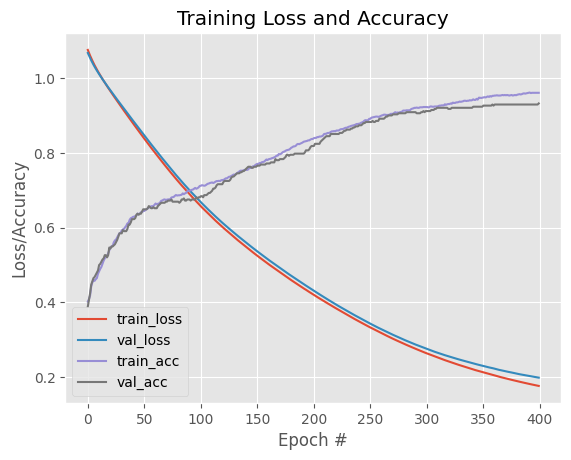

In [16]:
# Hiper-parámetros de nuestra red
lr = 0.01
n_epochs = 400
batch_size = 512

# Implementamos la red empleando Keras
model = Sequential()
model.add(Flatten())  # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple
model.add(Dense(64, activation="relu", name='Capa1'))  # Capa oculta con 64 unidades y función de activación ReLU
model.add(Dense(32, activation="relu", name='Capa2'))  # Otra capa oculta con 32 unidades y función de activación ReLU
model.add(Dense(16, activation="relu", name='Capa3'))  # Tercera capa oculta con 16 unidades y función de activación ReLU
model.add(Dense(3, activation="softmax", name='Capa_out'))  # Capa de salida con 3 unidades y activación softmax

# Compilamos y entrenamos
print("[INFO]: Entrenando red neuronal...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["accuracy"])

# Entrenar el modelo con Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=batch_size, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

print('-----------------------------------------------')

# Visualizar y printear el modelo y el número de parámetros:
print('Modelo y número de parametros')
print(model.summary())

# Predecir y mostrar una clasificación

predicTrain = model.predict(X_train, batch_size=batch_size)
predicVal = model.predict(X_val , batch_size=batch_size)
predicTest = model.predict(X_test, batch_size=batch_size)
predicted_categories = np.argmax(predicTest, axis=1)
true_categories = np.argmax(y_test, axis=1)

np.save('/content/drive/MyDrive/keepcoding_DL/MLP_predic_TrainClass.npy', predicTrain)
np.save('/content/drive/MyDrive/keepcoding_DL/MLP_predic_ValClass.npy', predicVal)
np.save('/content/drive/MyDrive/keepcoding_DL/MLP_predic_TestClass.npy', predicTest)



# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_categories, predicted_categories)
class_report = classification_report(true_categories, predicted_categories, target_names=['Cheap', 'Middle', 'Expensive'])
print(conf_matrix)
print(class_report)

## Conclusiones

- A la vista de los resultados, parece que el modelo tiene un rendimiento bastante bueno.
- Tanto los valores de precisión como los de recall presentan un alto rendimiento en la generalización de cada una de las 3 categorías.
- Tal vez podamos estar observando un poco de sobreajuste a los datos de entrenamiento, aún así, vemos que el accuracy en validación tiene un valor lo suficientemente alto como para deducir que estamos ante un modelo robusto que generaliza correctamente.

# Modelo 2D/imágenes:

# Redes Neuronales Convolucionales 

## 1. Carga de datos

In [17]:
imagenes_data = np.load('/content/drive/MyDrive/keepcoding_DL/images_KC.npy')
imagenes_data.shape

(2135, 224, 224, 3)

In [18]:

# Cargo los indices guardados previamente
path = '/content/drive/MyDrive/keepcoding_DL/'
idx_train_load = np.load(path + 'idx_train.npy')
idx_test_load = np.load(path + 'idx_test.npy')
idx_val_load = np.load(path + 'idx_val.npy')

# Asigno los indices a mis variables predictoras
X_train_img = imagenes_data[idx_train_load]
X_test_img = imagenes_data[idx_test_load]
X_val_img = imagenes_data[idx_val_load]
y_train_img = y_train
y_test_img = y_test
y_val_img = y_val

# Shape variables
print('Shape X_train:', X_train_img.shape)
print('Shape y_train:', y_train_img.shape)
print('Shape X_val:', X_val_img.shape)
print('Shape y_val:', y_val_img.shape)
print('Shape X_test:', X_test_img.shape)
print('Shape y_test:', y_test_img.shape)


Shape X_train: (1366, 224, 224, 3)
Shape y_train: (1366, 3)
Shape X_val: (342, 224, 224, 3)
Shape y_val: (342, 3)
Shape X_test: (427, 224, 224, 3)
Shape y_test: (427, 3)


In [ ]:
np.save('/content/drive/MyDrive/keepcoding_DL/y_train_img.npy', y_train_img)
np.save('/content/drive/MyDrive/keepcoding_DL/y_val_img.npy', y_val_img)
np.save('/content/drive/MyDrive/keepcoding_DL/y_test_img.npy', y_test_img)

### Visualizo una imagen

log_price                      5.521461
property_type                 Apartment
room_type               Entire home/apt
accommodates                          2
bathrooms                           1.0
bed_type                       Real Bed
cancellation_policy            flexible
cleaning_fee                       True
city                                NYC
instant_bookable                      f
latitude                      40.845674
longitude                    -73.908657
neighbourhood                   Tremont
number_of_reviews                     0
review_scores_rating                NaN
zipcode                         10457.0
bedrooms                            1.0
beds                                1.0
Price                             250.0
Price_Category                Expensive
Name: 1500, dtype: object


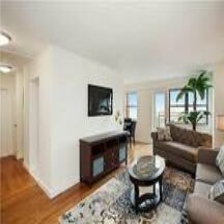

[[[0.7529412  0.7176471  0.68235296]
  [0.7058824  0.67058825 0.63529414]
  [0.7058824  0.67058825 0.63529414]
  ...
  [0.7411765  0.70980394 0.6666667 ]
  [0.73333335 0.7019608  0.65882355]
  [0.73333335 0.7019608  0.65882355]]

 [[0.72156864 0.6901961  0.6509804 ]
  [0.6784314  0.6431373  0.60784316]
  [0.6745098  0.6392157  0.6039216 ]
  ...
  [0.70980394 0.6784314  0.63529414]
  [0.7019608  0.67058825 0.627451  ]
  [0.69803923 0.67058825 0.62352943]]

 [[0.69411767 0.65882355 0.62352943]
  [0.64705884 0.6117647  0.5764706 ]
  [0.64705884 0.6117647  0.5764706 ]
  ...
  [0.6745098  0.6431373  0.6       ]
  [0.67058825 0.63529414 0.59607846]
  [0.6627451  0.63529414 0.5882353 ]]

 ...

 [[0.5411765  0.3372549  0.19215687]
  [0.47058824 0.26666668 0.11372549]
  [0.45882353 0.25490198 0.10196079]
  ...
  [0.5647059  0.45490196 0.37254903]
  [0.56078434 0.4509804  0.36862746]
  [0.5647059  0.45490196 0.37254903]]

 [[0.54901963 0.34117648 0.2       ]
  [0.4745098  0.27450982 0.1254902 ]


In [19]:
muestra_i = 1500
print(data.iloc[muestra_i])

R = imagenes_data[muestra_i,:,:,0]
G = imagenes_data[muestra_i,:,:,1]
B = imagenes_data[muestra_i,:,:,2]
rgb_muestra = np.stack([B, G, R], axis=2)


cv2_imshow(rgb_muestra*255) # Multiplico por 255 por que nuestras imagenes ya vienen normalizadas
print(imagenes_data[muestra_i]) # Visualizamos los valores.

# CNN 1

Epoch 1/50
86/86 [==============================] - 16s 153ms/step - loss: 12.3837 - accuracy: 0.3265 - val_loss: 1.0985 - val_accuracy: 0.3363
Epoch 2/50
86/86 [==============================] - 12s 144ms/step - loss: 1.0836 - accuracy: 0.3895 - val_loss: 1.0985 - val_accuracy: 0.3363
Epoch 3/50
86/86 [==============================] - 12s 145ms/step - loss: 1.0496 - accuracy: 0.4531 - val_loss: 1.0985 - val_accuracy: 0.3363
Epoch 4/50
86/86 [==============================] - 13s 146ms/step - loss: 0.9861 - accuracy: 0.5139 - val_loss: 1.0984 - val_accuracy: 0.3392
Epoch 5/50
86/86 [==============================] - 12s 143ms/step - loss: 0.8149 - accuracy: 0.6420 - val_loss: 1.1007 - val_accuracy: 0.3099
Epoch 6/50
86/86 [==============================] - 13s 146ms/step - loss: 0.6108 - accuracy: 0.7372 - val_loss: 1.1182 - val_accuracy: 0.3012
Epoch 7/50
86/86 [==============================] - 12s 143ms/step - loss: 0.4253 - accuracy: 0.8411 - val_loss: 1.1860 - val_accuracy: 0.324

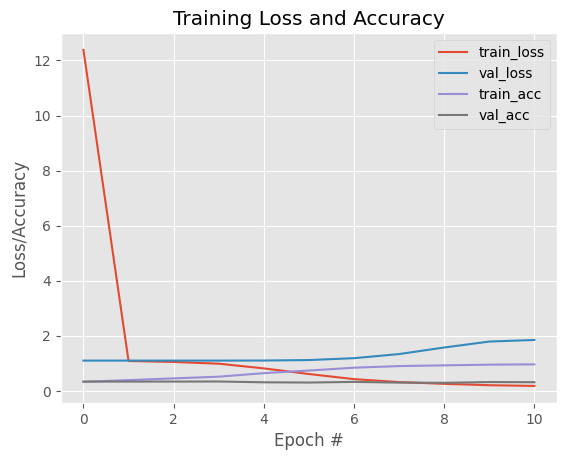

-----------------------------------------------
Modelo y número de parametros
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 64)      256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 dropout_6 (Dropout)         (None, 222, 222, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      18464     
                                                                 
 batch_normalization_7 (Bat  (None, 220, 2

In [ ]:
learning_rate = 0.001
lr_decay = 0.001
n_epochs = 50
batch_size = 16

earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", # métrica o función de pérdida en donde nos fijaremos para saber que el over-fitting está empezando
    min_delta=0.001, # Mínimo cambio esperado en la métrica monitoreada (val_loss en este caso) para sumar 1 al contador de patience
    patience=10, # Número de epochs a esperar 'viendo' cómo la métrica no mejora
)


# Inizializamos el modelo
model = Sequential()

# Definimos una capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3))) ## CODE ##
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Definimos una segunda capa convolucional
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))## CODE ##
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Definimos una tercera capa convolucional
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))## CODE ##
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Añadimos nuestro clasificador
model.add(Flatten())
model.add(Dense(32, activation='relu'))## CODE ##
model.add(Dense(3, activation='softmax'))## CODE ##


# Compilamos el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=10,
      decay_rate=0.96,
      staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy']) ## CODE ##

# Entrenamos el modelo
H= model.fit(X_train_img, y_train_img, validation_data=(X_val_img, y_val_img), batch_size=batch_size, shuffle=True, epochs=n_epochs, callbacks=[earlyStopping_callback])

# Evaluamos el modelo
scores = model.evaluate(X_test_img, y_test_img)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(X_test_img, y_test_img)
print(f'Test accuracy: {test_accuracy}')

# Obtener el número de épocas realmente entrenadas
epochs_realizadas = len(H.history['loss'])

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_realizadas), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs_realizadas), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_realizadas), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


print('-----------------------------------------------')

# Visualizar y printear el modelo y el número de parámetros:
print('Modelo y número de parametros')
print(model.summary())

# Predecir y mostrar una clasificación

predicTrain = model.predict(X_train_img, batch_size=batch_size)
predicVal = model.predict(X_val_img , batch_size=batch_size)
predicTest = model.predict(X_test_img, batch_size=batch_size)
predicted_categories = np.argmax(predicTest, axis=1)
true_categories = np.argmax(y_test_img, axis=1)

np.save('/content/drive/MyDrive/keepcoding_DL/CNN1_predic_TrainClass.npy', predicTrain)
np.save('/content/drive/MyDrive/keepcoding_DL/CNN1_predic_ValClass.npy', predicVal)
np.save('/content/drive/MyDrive/keepcoding_DL/CNN1_predic_TestClass.npy', predicTest)



# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_categories, predicted_categories)
class_report = classification_report(true_categories, predicted_categories, target_names=['Cheap', 'Middle', 'Expensive'])
print(conf_matrix)
print(class_report)

## Conclusiones

- La precisión del conjunto de entrenamiento mejora notablemente, alcanzando un porcentaje muy alto, por lo que deducimos que el modelo aprende de forma efectiva.
- Por el contrario, observamos que no ocurre lo mismo con el accuracy de validación y de prueba, los cuales se estancan por debajo del 35%; el modelo no está generalizando correctamente y está sobreajustado.
- La función de pérdida del conjunto de validación no solo no disminuye, sino que aumenta en algunas épocas, otro síntoma de sobreajuste.
- Finalmente, debido a la no mejora de la función de pérdida del conjunto de validación, el early stopping detiene el entrenamiento.
- Se observa en la matriz del confusion que ninguna de las categorias está consiguiendo muy buenos resultados en la predicción sus respectivas clases.
- Los valores del recall en cada categoria son muy bajos por lo que se deduce que el modelo no identifica correctamente los datos con los que no ha entrenado.
- El F1-Score muestra un rendimiento deficiente.

# CNN 2

Epoch 1/50
86/86 [==============================] - 19s 125ms/step - loss: 1.1039 - accuracy: 0.3389 - val_loss: 1.0984 - val_accuracy: 0.3421
Epoch 2/50
86/86 [==============================] - 9s 101ms/step - loss: 1.0963 - accuracy: 0.3594 - val_loss: 1.0984 - val_accuracy: 0.3421
Epoch 3/50
86/86 [==============================] - 9s 103ms/step - loss: 1.0930 - accuracy: 0.3748 - val_loss: 1.0985 - val_accuracy: 0.3421
Epoch 4/50
86/86 [==============================] - 9s 103ms/step - loss: 1.0860 - accuracy: 0.3960 - val_loss: 1.0989 - val_accuracy: 0.3421
Epoch 5/50
86/86 [==============================] - 9s 102ms/step - loss: 1.0821 - accuracy: 0.4070 - val_loss: 1.0987 - val_accuracy: 0.3421
Epoch 6/50
86/86 [==============================] - 9s 104ms/step - loss: 1.0797 - accuracy: 0.4026 - val_loss: 1.0983 - val_accuracy: 0.3421
Epoch 7/50
86/86 [==============================] - 9s 106ms/step - loss: 1.0747 - accuracy: 0.4114 - val_loss: 1.0962 - val_accuracy: 0.3421
Epoch

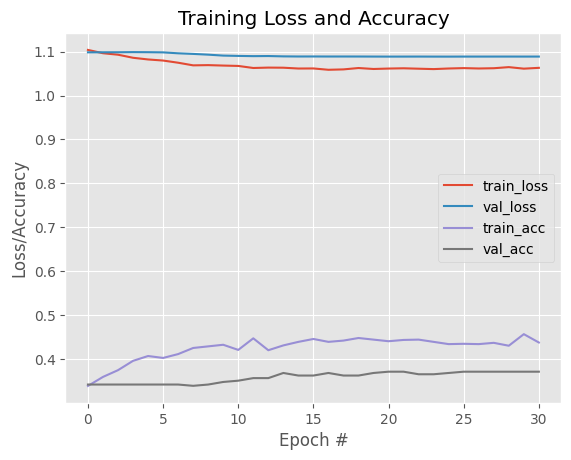

-----------------------------------------------
Modelo y número de parametros
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 222, 222, 64)      256       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 dropout_9 (Dropout)         (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                          

In [ ]:
learning_rate = 0.001
lr_decay = 0.001
n_epochs = 50
batch_size = 16

earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", # métrica o función de pérdida en donde nos fijaremos para saber que el over-fitting está empezando
    min_delta=0.001, # Mínimo cambio esperado en la métrica monitoreada (val_loss en este caso) para sumar 1 al contador de patience
    patience=10, # Número de epochs a esperar 'viendo' cómo la métrica no mejora
)

# Inicializamos el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadimos una capa de MaxPooling

# Segunda capa convolucional
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadimos otra capa de MaxPooling

# Tercera capa convolucional
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadimos otra capa de MaxPooling

# Añadimos nuestro clasificador
model.add(GlobalAveragePooling2D())  # Reemplazo de Flatten por GlobalAveragePooling2D

# Capas densas
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compilamos el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=10,
      decay_rate=0.96,
      staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy']) ## CODE ##

# Entrenamos el modelo
H= model.fit(X_train_img, y_train_img, validation_data=(X_val_img, y_val_img), batch_size=batch_size, shuffle=True, epochs=n_epochs, callbacks=[earlyStopping_callback])

# Evaluamos el modelo
scores = model.evaluate(X_test_img, y_test_img)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(X_test_img, y_test_img)
print(f'Test accuracy: {test_accuracy}')

# Obtener el número de épocas realmente entrenadas
epochs_realizadas = len(H.history['loss'])

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_realizadas), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs_realizadas), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_realizadas), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

print('-----------------------------------------------')

# Visualizar y printear el modelo y el número de parámetros:
print('Modelo y número de parametros')
print(model.summary())

# Predecir y mostrar una clasificación

predicTrain = model.predict(X_train_img, batch_size=batch_size)
predicVal = model.predict(X_val_img , batch_size=batch_size)
predicTest = model.predict(X_test_img, batch_size=batch_size)
predicted_categories = np.argmax(predicTest, axis=1)
true_categories = np.argmax(y_test_img, axis=1)

np.save('/content/drive/MyDrive/keepcoding_DL/CNN2_predic_TrainClass.npy', predicTrain)
np.save('/content/drive/MyDrive/keepcoding_DL/CNN2_predic_ValClass.npy', predicVal)
np.save('/content/drive/MyDrive/keepcoding_DL/CNN2_predic_TestClass.npy', predicTest)



# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_categories, predicted_categories)
class_report = classification_report(true_categories, predicted_categories, target_names=['Cheap', 'Middle', 'Expensive'])
print(conf_matrix)
print(class_report)

## Conclusiones

- Vemos por lo resultados de esta red que el modelo no esta generalizando correctamente.
- Llega un momento en el que el acc de validacion se queda estancado.
- El error o la "pérdida" del modelo en un conjunto de datos de validación y finalmente el earlyStopping detiene el entrenamiento.
- Ademas observamos que existe un claro sesgo a clasificar practicamente todo hacia 'cheap'.